# find three most important channels for EEG data
## basic idea:
### 1.divided the channel into three parts——by Hierarchical Clustering
### 2.give the most important channel in each class: 
within each class give a score for each channel and sort the channel's score.
the score here is given by the correlation for the channel with others(the sum of correlation with every channel), it can also given by some other rules.

new package here is: pyts

In [33]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from scipy.ndimage import uniform_filter1d, sobel, prewitt, fourier_gaussian, fourier_shift
from pyts.decomposition import SingularSpectrumAnalysis # SSA for timeseries
import heapq # used in the sort of the n-largest index of a vector
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

## get the eye open EEG data
firstly, we get the eye open data from eegbci (from the python package mne.datasets)

In [30]:
# Define the parameters 
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

# Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
# Combine all loaded runs
raw_obj = concatenate_raws(raws)
motor_imagery_data = raw_obj.get_data()

runs = 1  # use only motor execution (left vs right)
# Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
# Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
# Combine all loaded runs
raw_obj = concatenate_raws(raws)
base_open_data = raw_obj.get_data()

Extracting EDF parameters from /Users/caozilu/Desktop/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/caozilu/Desktop/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/caozilu/Desktop/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/caozilu/Desktop/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  

## obtain the main part of each channel
   using the first component of SSA.


In [31]:
X = base_open_data

# We decompose the time series into three subseries
window_size = 15
groups = [np.arange(i, i + 5) for i in range(0, 11, 5)]

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=15, groups=groups)
X_ssa = ssa.fit_transform(X)

TSeriesMatrix=np.zeros([X.shape[0],X.shape[1]])

for i in range(X.shape[0]):
    TSeriesMatrix[i,:]=X_ssa[i,1]

FCM = np.corrcoef(TSeriesMatrix)
corr_sum=sum(FCM,1)
main_channel=np.where(corr_sum==np.max(corr_sum))
for i in range(len(main_channel)):
    print("main_channel is",main_channel[i])

main_channel is [18]


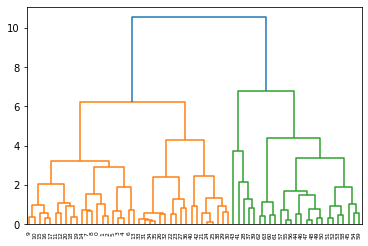

In [71]:
%matplotlib inline
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(TSeriesMatrix)
linkage_data = linkage(FCM, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

 ### 1.divided the channel into three parts——by Hierarchical Clustering

class 1: channels (array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 41]),)
class 2: channels (array([40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63]),)
class 3: channels (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]),)


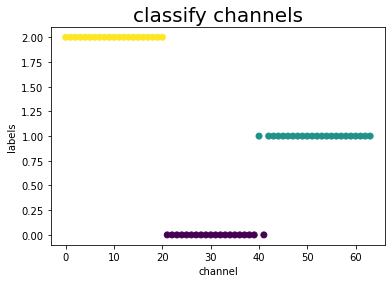

In [ ]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
channels=range(X.shape[0])
labels = hierarchical_cluster.fit_predict(TSeriesMatrix) # Can change to original data matrix
channels_classify = list(zip(channels, labels))
cs=plt.scatter(channels,labels,c=labels)

plt.title('classify channels', fontsize=20)
plt.xlabel('channel')
plt.ylabel('labels')

class1_channel=np.where(labels==0)
class2_channel=np.where(labels==1)
class3_channel=np.where(labels==2)
print("class 1: channels",class1_channel)
print("class 2: channels",class2_channel)
print("class 3: channels",class3_channel)

#### check the correlation of the three class

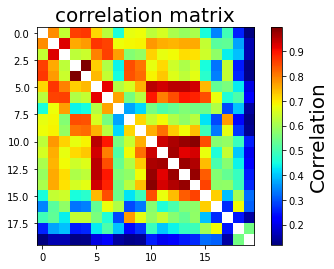

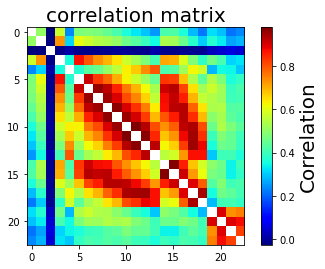

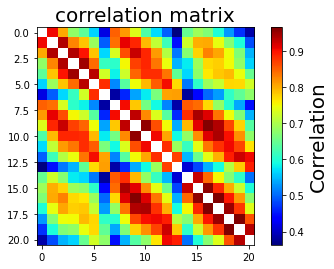

In [47]:
Timeseries_class1=TSeriesMatrix[class1_channel[0],:]
Timeseries_class2=TSeriesMatrix[class2_channel[0],:]
Timeseries_class3=TSeriesMatrix[class3_channel[0],:]

FCM_class1 = np.corrcoef(Timeseries_class1)
FCM_class2 = np.corrcoef(Timeseries_class2)
FCM_class3 = np.corrcoef(Timeseries_class3)

FCM_1 = FCM_class1
FCM_2 = FCM_class2
FCM_3 = FCM_class3
plt.figure(1)
np.fill_diagonal(FCM_1,np.nan)
cs1=plt.imshow(FCM_1, cmap='jet', aspect='equal', interpolation='none')
plt.title('correlation matrix', fontsize=20)
axcb=plt.colorbar(cs1)
axcb.set_label('Correlation', fontsize=20)
plt.figure(2)
np.fill_diagonal(FCM_2,np.nan)
cs2=plt.imshow(FCM_2, cmap='jet', aspect='equal', interpolation='none')
plt.title('correlation matrix', fontsize=20)
axcb=plt.colorbar(cs2)
axcb.set_label('Correlation', fontsize=20)
plt.figure(3)
np.fill_diagonal(FCM_3,np.nan)
cs3=plt.imshow(FCM_3, cmap='jet', aspect='equal', interpolation='none')
plt.title('correlation matrix', fontsize=20)
axcb=plt.colorbar(cs3)
axcb.set_label('Correlation', fontsize=20)

## 2.give the most important channel in each class: 
### shows the most important channel for each class
give a score of the channel for each class
### give a sort of the channel/brain region
   define the most important channel as most corr with each channel
   for channel i, add the correlation between timeseries xi and xj (j does not equal i) 

In [72]:
corr_sum1=sum(np.nan_to_num(FCM_class1),1)
main_channel=np.where(corr_sum1==np.max(corr_sum1))
main_channel1=class1_channel[0][main_channel]
for i in range(len(main_channel)):
    print("main_channel is",main_channel1[i])

corr_sum2=sum(np.nan_to_num(FCM_class2),1)
main_channel=np.where(corr_sum2==np.max(corr_sum2))
main_channel2=class2_channel[0][main_channel]
for i in range(len(main_channel)):
    print("main_channel is",main_channel2[i])
    
corr_sum3=sum(np.nan_to_num(FCM_class3),1)
main_channel=np.where(corr_sum3==np.max(corr_sum3))
main_channel3=class3_channel[0][main_channel]
for i in range(len(main_channel)):
    print("main_channel is",main_channel3[i])

three_channels=[main_channel1[0],main_channel2[0],main_channel3[0]]
print('three_channels',three_channels)

main_channel is 26
main_channel is 49
main_channel is 9
three_channels [26, 49, 9]
